---
title: "Hypothesis-driven feature engineering"
date: 2024-11-19T19:17:47+08:00
categories:
  - Blog
tags:
  - Feature engineering
  - Genomics
classes: wide
---

I'm starting a machine learning project to use microbial communities as biosensors for redox potential.
Why is this important?
Well, redox potential (written as Eh or ORP) reflects the tendency for chemical species to be oxidized or reduced; that is, to lose or gain electrons.
Eh measurements using redox probes are useful for characterizing [*differences between samples*](https://doi.org/10.1071/EN17158), even if they can't be used to quantify chemical species because of non-equilibrium effects.
Moreover, redox gradients are basic features of many microbial habitats and play a role in determining what kinds of metabolism are used and how communities react to environmental perturbations, such as [soil disinfestation](https://doi.org/10.1007/s00248-019-01477-6).

Redox potential is not always measured or reported in microbial ecology studies.
Therefore, a useful ML application would predict Eh from taxonomic abundances inferred from 16S rRNA sequences, which are widely reported.
Such a model would use taxonomic abundances as the features and Eh7 ([Eh corrected to pH 7](https://doi.org/10.1016/j.aca.2015.11.052)) as a target variable.
But it probably wouldn't be enough.
The authors of a [recent preprint](https://doi.org/10.1101/2024.03.22.586313) describe how genomic features, including chemical metrics of proteins, are useful for predicting growth conditions of microbes.
That study was about making predictions from genomes; for this project I want to do something similar, but for communities.

16S rRNA sequencing tells about the abundances of different taxa, but not about protein sequences.
Reference genomes are a source of protein sequences.
In particular, the [Genome Taxonomy Database](https://gtdb.ecogenomic.org/) (GTDB) is a valuable resource because it provides both reference genomes and 16S rRNA sequences that can be used for taxonomic classification, ensuring consistent naming.
No more messy cross-database taxonomic mapping! 😁
To put this into practice, I created the [**chem16S**](https://doi.org/10.32614/CRAN.package.chem16S) package to combine user-provided taxonomic classifications with the genome-based amino acid compositions of proteins from archaea and bacteria to predict chemical metrics and other properties such as protein length, molecular weight, and isoelectric point.

Now we should select a chemical metric that is tied to redox conditions.
This is where the evolutionary oxidation hypothesis comes in: that oxidizing conditions favor the evolution of oxidized protein sequences.
If this hypothesis holds water, then carbon oxidation state (*Z*<sub>C</sub>) would be useful for predicting environments from genomes.
I'm working on a [different project to track Earth's oxygenation in the genomic record](https://github.com/jedick/JMDplots/blob/main/R/genoGOE.R).
Even without knowing the evolutionary details, [community-level *Z*<sub>C</sub> is correlated with redox potential in modern environments](https://doi.org/10.1128/msystems.00014-23), providing foundational support for this hypothesis.

What's this “community-level *Z*<sub>C</sub>”?
It's the carbon oxidation state for predicted proteins in all microbial taxa, weighted by taxonomic abundances in the community.
Calculating a single value of *Z*<sub>C</sub> for each sample was fine for previous studies attempting to test the hypothesis, but we need more features to make accurate predictions in machine learning.
Therefore, I have added a function to **chem16S**, [`get_metric_byrank()`](https://chnosz.net/chem16S/manual/get_metric_byrank.html), that calculates *Z*<sub>C</sub> or other chemical metrics by aggregating amino acid compositions up to a given taxonomic rank.
For example, this agreggates amino acid composition up to the first rank (`rootrank`), which includes all community members, so it outputs the community-level *Z*<sub>C</sub>:

In [1]:
library(chem16S)
RDPfile <- system.file("extdata/RDP-GTDB_220/SMS+12.tab.xz", package = "chem16S")
RDP <- read_RDP(RDPfile)
map <- map_taxa(RDP)
get_metric_byrank(RDP, map, rank = "rootrank")

[1] "read_RDP [SMS+12.tab.xz]: 90% of classifications at genus level"
[1] "read_RDP [SMS+12.tab.xz]: removing domain_Bacteria (0.9%)"
[1] "read_RDP [SMS+12.tab.xz]: range of counts is 368 to 572"
[1] "map_taxa [SMS+12.tab.xz]: mapping rate to GTDB_220 taxonomy is 100.0%"


,Root
,<dbl>
mgm4946223.3,-0.1900768
mgm4946224.3,-0.2107628
mgm4946225.3,-0.1839642
mgm4946226.3,-0.1618029
mgm4946227.3,-0.1648361


The 16S rRNA data for this example come from [Swingley et al. (2012)](https://doi.org/10.1371/journal.pone.0038108). The values of community-level *Z*<sub>C</sub> for the first two samples (on the rows) are lower than the others, consistent with more reducing conditions closer to the source of the hot spring where these samples were taken - Rosette Geyser ("[Bison Pool](https://doi.org/10.1371/journal.pone.0022782.g002)") in Yellowstone National Park.
But what if we look at carbon oxidation state for each phylum rather than whole communities?

In [2]:
get_metric_byrank(RDP, map, rank = "phylum")

,Acidobacteriota,Aquificota,Armatimonadota,Bacillota,Bacteroidota,CSP1.3,Chloroflexota,Cyanobacteriota,DRYD01,Deinococcota,Elusimicrobiota,Gemmatimonadota,Halobacteriota,Patescibacteria,Pseudomonadota,Spirochaetota,Thermoplasmatota,Thermoproteota,Thermotogota,WOR.3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mgm4946223.3,NaN,-0.2240167,-0.1521823,-0.1936423,NaN,NaN,-0.1669757,NaN,NaN,-0.1936716,NaN,NaN,NaN,-0.2624131,-0.1418044,NaN,NaN,-0.1795643,NaN,-0.2405404
mgm4946224.3,NaN,-0.2240721,NaN,NaN,NaN,NaN,NaN,-0.1351809,NaN,-0.1936716,NaN,NaN,NaN,NaN,-0.1393235,NaN,-0.126997,-0.2117681,NaN,NaN
mgm4946225.3,NaN,-0.2238583,-0.1475908,-0.1920696,-0.1720817,NaN,-0.1647598,NaN,-0.2541078,-0.1932030,NaN,-0.1423286,NaN,-0.2459384,-0.1602478,NaN,NaN,-0.1836186,NaN,-0.2163193
mgm4946226.3,-0.1527581,NaN,NaN,-0.2005670,-0.1659640,-0.1443808,-0.1530366,-0.1599769,NaN,-0.1714178,NaN,NaN,NaN,-0.2262955,-0.1577910,NaN,NaN,NaN,NaN,NaN
mgm4946227.3,NaN,-0.2240721,-0.1473414,NaN,-0.1697553,NaN,-0.1558235,-0.1608831,NaN,-0.1714178,-0.2525205,NaN,-0.1618895,-0.2321619,-0.1566022,-0.2360288,NaN,-0.1770686,-0.2159915,NaN


Oh yeah!
We've just engineered chemical features for 20 phyla from their genomes and abundances.
That last bit is important: the reason that *Z*<sub>C</sub> isn't constant for a given phylum is that it comes from aggregating the abundance-weighted amino acid compositions of all taxa within that phylum.
This also explains why there are NA values; these are where taxa in a given phylum were not identified at that site.
Note that this dataset is from 2012; the greater sequencing depth of modern surveys reduces the occurrence of NA values that would have to be dealt with before fitting an ML model.

Just as a reminder, the amino acid compositions come from reference genomes in GTDB, so we are indeed mixing in information that isn't available from the 16S rRNA classifications alone.
But is it realistic?
Fortunately there are metagenomes for these same sites at Bison Pool that we can use for comparison.
Let's first look at the trend of *Z*<sub>C</sub> derived from 16S rRNA and reference genomes:

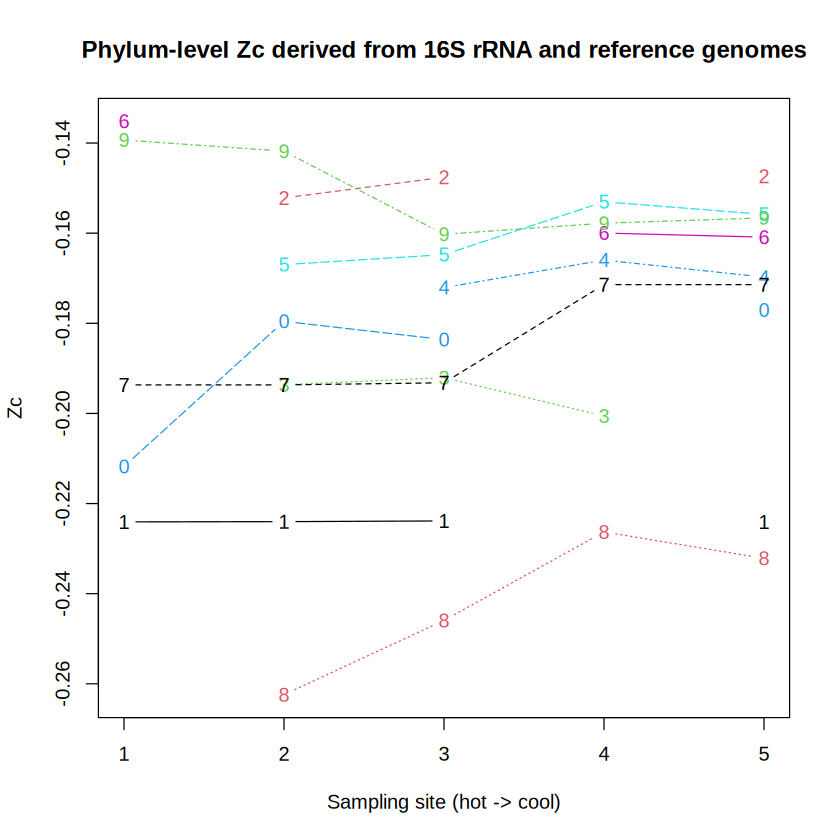

In [3]:
phylum_Zc <- get_metric_byrank(RDP, map, rank = "phylum")
# Keep phyla present in at least two samples
n_values <- colSums(!sapply(phylum_Zc, is.na))
phylum_Zc <- phylum_Zc[n_values > 2]
# Swap the first two samples to get them in the right location
# (MG-RAST accession numbers for these samples are not in spatial order)
phylum_Zc <- phylum_Zc[c(2, 1, 3, 4, 5), ]
matplot(phylum_Zc, type = "b", xlab = "Sampling site (hot -> cool)", ylab = "Zc")
title("Phylum-level Zc derived from 16S rRNA and reference genomes")

Now let's look at the values calculated from metagenomically inferred protein sequences.
This plot shows the same data as in [Dick and Shock (2013)](https://doi.org/10.1371/journal.pone.0072395).

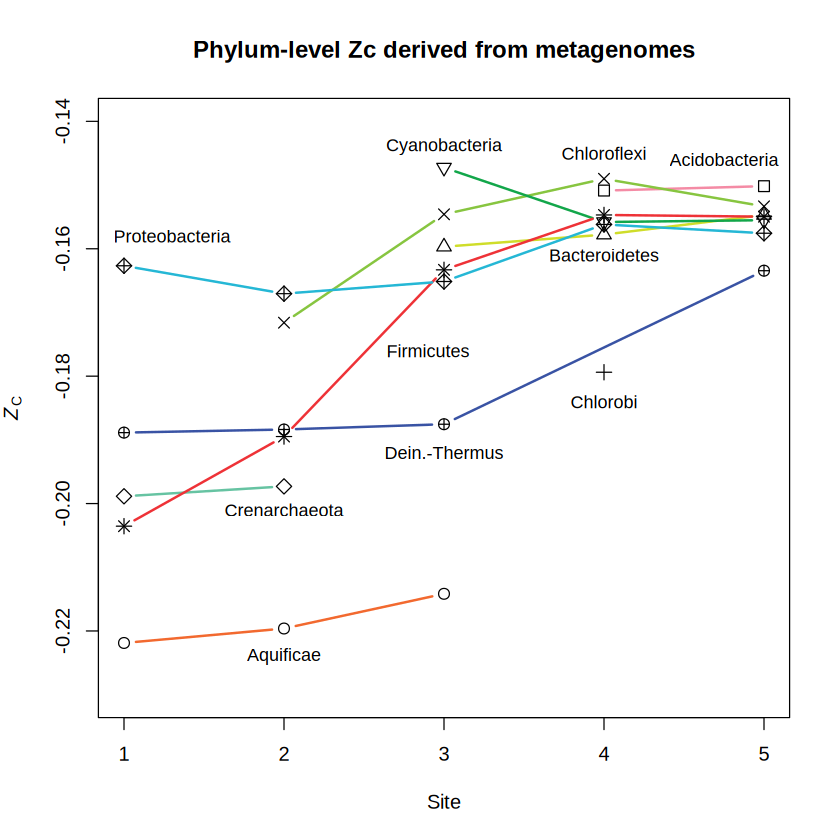

In [4]:
suppressMessages(library(JMDplots))
bison2(plots = 2, add.titles = FALSE)
title("Phylum-level Zc derived from metagenomes")

While there are some exceptions, phylum-level proteins inferred from 16S rRNA and reference genomes or from metagenomes tend to be more oxidized in samples more distal from the hot-spring source (i.e., the higher-numbered sites).
This is reflected not only in the prevalence of relatively oxidized phyla, but also in differences for particular phyla; the latter is the exciting new feature to use.

If you're asking why we don't just use metagenomes to generate chemical features, it's because there are loads more 16S rRNA sequence datasets in public databases.
Getting the most out of that data (and future microbial community surveys) is the data-driven part of this project.

To sum up, `get_metric_byrank()` is now available in the [development version of **chem16S** on GitHub](https://github.com/jedick/chem16S) for generating chemical features at a given rank from taxonomic classifications provided by the user, either as RDP Classifier output or as a [**phyloseq**](https://doi.org/10.18129/B9.bioc.phyloseq ) object.
Stay tuned for updates about using these features to predict redox potential!